In [4]:
from utils import dataloader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload  

import matplotlib.pyplot as plt

import numpy as np

import torch as th
import torch.nn as nn
import os
from datetime import datetime
import matplotlib as mpl
import torch.optim as optim
import pytorch_ssim

import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms

In [25]:
dataloader = reload(dataloader)

plotsize = 15

partitions = dataloader.DataPartitions(
    past_frames=4,
    future_frames=1,
    root="../datasets/baganza/",
    partial=0.2
)

dataset = dataloader.DataGenerator(
    root="../datasets/baganza/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 4),
    output_dim=(partitions.future_frames, 256, 256, 3),
    batch_size=4,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
    dynamicity = 1e-2
)

In [26]:
X, Y, extra_batch = dataset.get_data()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


[x] 1 areas found
. . . . . . . . . . . 
[100%] 11 valid sequences loaded


In [27]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

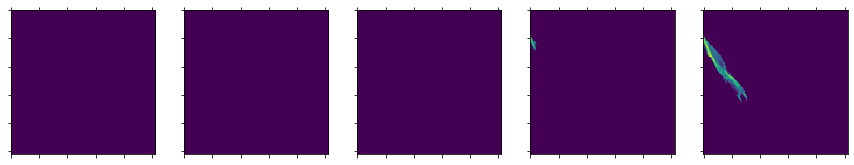

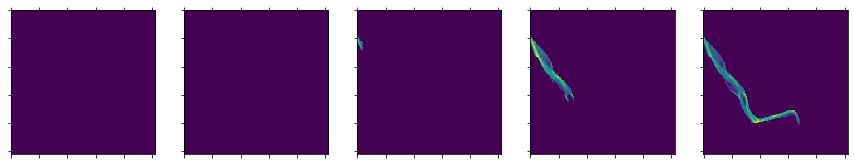

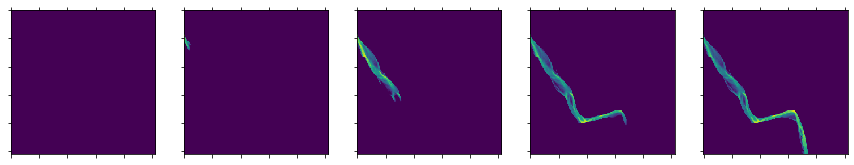

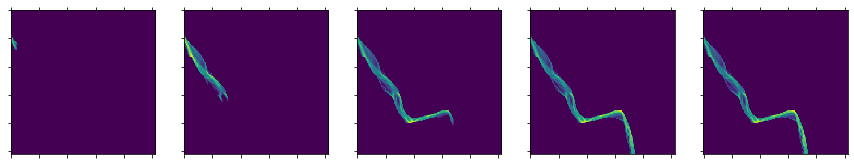

In [29]:
# Valid sequences
for i, batch in enumerate(X_train):
    for j, sequence in enumerate(batch):
        
        # first three channels (dep, vvx, vvy): x/y aligned
        sequence = np.concatenate((sequence[:,:,:,:3], y_train[i,j]), axis=0)
    
        fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for k,frame in enumerate(sequence):   # x frames
            axs[k].matshow(frame[:,:,0])
        

In [30]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: -0.499941
BTM min: -0.899293
DEP max: 1.87241
VEL max: 2.16561
BTM max: 1.97168


### Model

In [2]:
import torch.nn.functional as F
from functools import partial

In [25]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [14]:
'''
weights_path = "runs/train_15_04_07_2021_23_28_19/model.weights"
net.load_state_dict(th.load(weights_path))
'''

'\nweights_path = "runs/train_15_04_07_2021_23_28_19/model.weights"\nnet.load_state_dict(th.load(weights_path))\n'

In [37]:
if th.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = th.device(dev)

In [39]:
from models.resnet import convlstm
convlstm = reload(convlstm)

net = convlstm.ConvLSTM(
    input_dim = 4, 
    hidden_dim = 3, 
    kernel_size = (3,3), 
    num_layers = 3, 
    batch_first = True, 
    bias = True, 
    return_all_layers = False).to(device) # False: many to one

# _, last_states = net(x)
# h = last_states[0][-1]  # 0 for layer index, 0 for h index


In [40]:
criterion = nn.MSELoss() # reduction='sum'
ssim_loss = pytorch_ssim.SSIM()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [41]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [42]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [43]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [44]:
# passaggio a channel first
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [45]:
losses = []
errors = []
test_errors = []

In [48]:
_, last_states = net(X_train[0])
h = last_states[0][-1]  # 0 for layer index, 0 for h index
print(h.shape)
print(y_train[0].shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 1, 256, 256])


In [51]:
epochs = 200

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        # ---- Predicting
        _, last_states = net(X_train[0])
        outputs = last_states[0][-1]  # 0 for layer index, 0 for h index

        # ---- Loss and training
        loss = criterion(outputs,  y_train[i,:,:,0,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())

        print("batch {} - loss {}".format(i, loss.item()))

    if epoch % 3 == 0:

        k = np.random.randint(len(X_test))

        _, last_states = net(X_test[k])
        outputs = last_states[0][-1]  # 0 for layer index, 0 for h index

        test_loss = criterion(outputs[0],  y_test[k,:,:,0,:,:])
        print("test loss: {}".format(test_loss.item()))

        #------------------------------
        '''
        fig, axs = plt.subplots(1, outputs[0].shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for j,frame in enumerate(outputs[0]):
            axs[j].matshow(frame[0].cpu().detach().numpy())

        plt.show()
        '''
        #------------------------------

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

batch 0 - loss 0.04608983173966408
test loss: 0.08543018251657486
batch 0 - loss 0.046017106622457504
batch 0 - loss 0.045945942401885986
batch 0 - loss 0.045875340700149536
test loss: 0.0851598009467125
batch 0 - loss 0.04580521956086159
batch 0 - loss 0.04573655128479004
batch 0 - loss 0.0456685833632946
test loss: 0.08490046113729477
batch 0 - loss 0.04560104385018349
batch 0 - loss 0.04553511366248131
batch 0 - loss 0.04546976089477539
test loss: 0.0846497043967247
batch 0 - loss 0.04540492221713066
batch 0 - loss 0.04534168541431427
batch 0 - loss 0.04527895152568817
test loss: 0.08441024273633957
batch 0 - loss 0.045216966420412064
batch 0 - loss 0.045156095176935196
batch 0 - loss 0.04509648308157921
test loss: 0.08417978882789612
batch 0 - loss 0.045037005096673965
batch 0 - loss 0.044978708028793335
batch 0 - loss 0.04492169991135597
test loss: 0.08396122604608536
batch 0 - loss 0.04486522078514099
batch 0 - loss 0.04480952396988869
batch 0 - loss 0.04475473240017891
test loss

KeyboardInterrupt: 

In [24]:
'''
num_run = len(os.listdir("runs/")) + 1
now = datetime.now()
foldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))
os.mkdir("runs/" + foldername)

weights_path = "runs/" + foldername + "/model.weights"
th.save(net.state_dict(), weights_path)
'''

'\nnum_run = len(os.listdir("runs/")) + 1\nnow = datetime.now()\nfoldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))\nos.mkdir("runs/" + foldername)\n\nweights_path = "runs/" + foldername + "/model.weights"\nth.save(net.state_dict(), weights_path)\n'

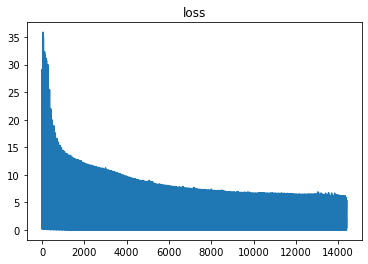

In [25]:
mpl.rcParams['text.color'] = 'k'

plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

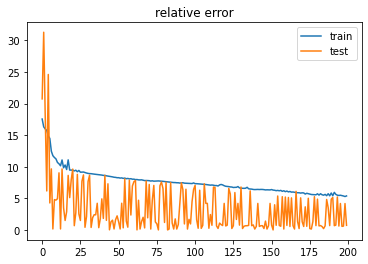

In [26]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


In [27]:
mpl.rcParams['text.color'] = 'w'
prep = Preprocessing()

k = 4
======== Past frames ========


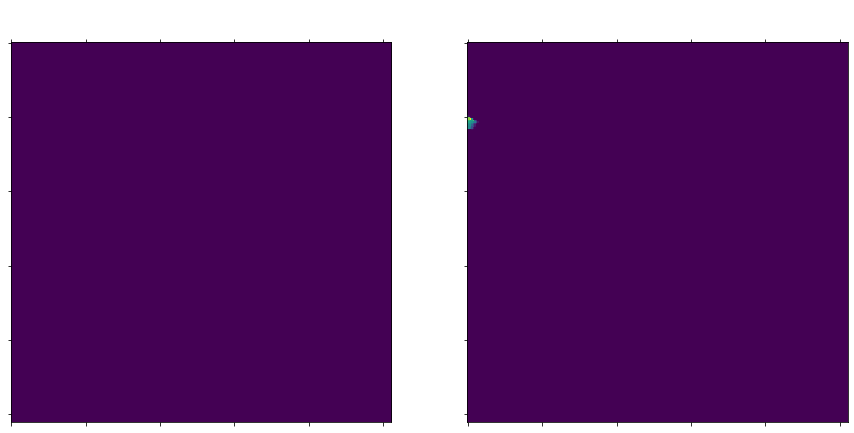

======== True Future vs Predicted frames ========


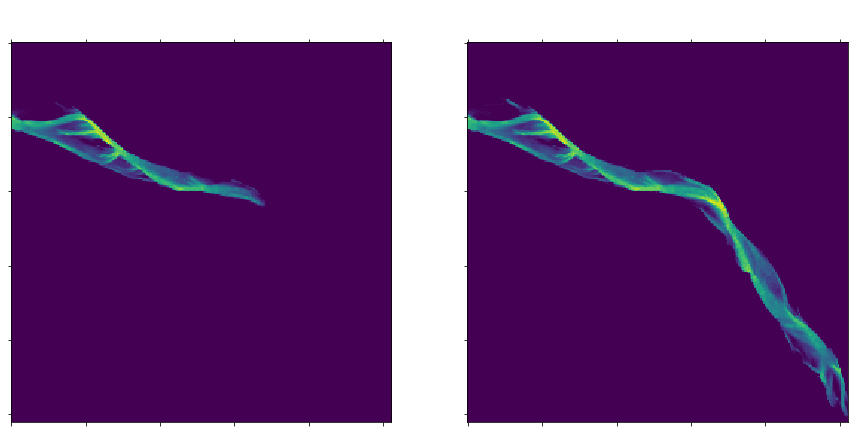

[[1.38497   1.4890387 1.6472039 1.681845  1.7259423]
 [1.4096096 1.5222852 1.6537913 1.689349  1.753241 ]
 [1.2188122 1.2962141 1.4281406 1.4494182 1.5186938]
 [1.134476  1.1967351 1.2965041 1.3054746 1.4190581]
 [1.3130611 1.3328977 1.4048684 1.3647956 1.6162078]]
#-------------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



[[3.4392052 3.501412  3.6003442 3.6218252 4.1092973]
 [3.6598983 3.7052217 3.7982721 3.8278768 4.3921347]
 [3.5096087 3.519772  3.5940642 3.6025963 4.1965156]
 [4.0407133 4.0142846 4.0385365 4.0438952 4.795246 ]
 [3.8747966 3.800887  3.8086376 3.7790735 4.581322 ]]
#-------------
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]





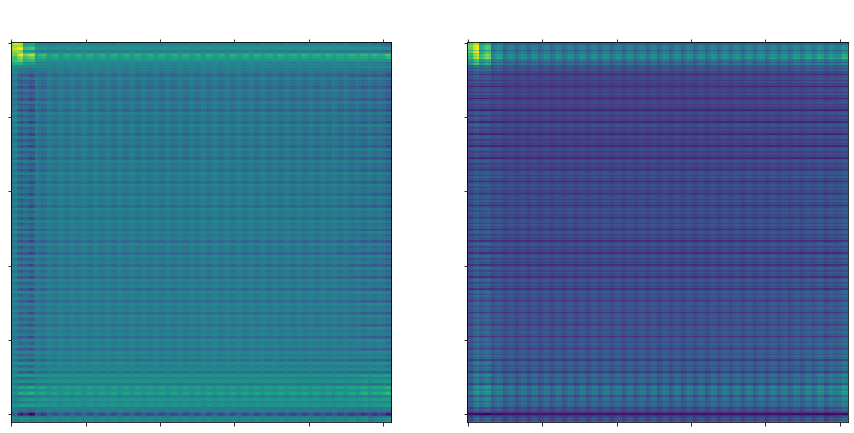

In [28]:
j = np.random.randint(len(y_test))
j = 3
m = 2
k = 4

print("k = {}".format(k))

#k = 5
input = th.unsqueeze(X_test[j, m], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0, 0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[j,m,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    attention_mask = outputs[0,1,i].cpu().detach().numpy()
    y_frame = frame.cpu().detach().numpy()
    y_true = y_test[j,m,0,i].cpu().detach().numpy()

    y_frame = np.dot(y_frame, attention_mask)
    y_true = np.dot(y_true, attention_mask)

    print(y_frame[:5,:5])
    print("#-------------")
    print(y_true[:5,:5])
    print("\n\n")

    ssim = prep.pytorch_ssim(y_true, y_frame).item()
    axs[i].matshow(y_frame)
    axs[i].set_title('ssim = {}'.format(ssim))

plt.show()
#------------------------------

k = 4
======== Past frames ========


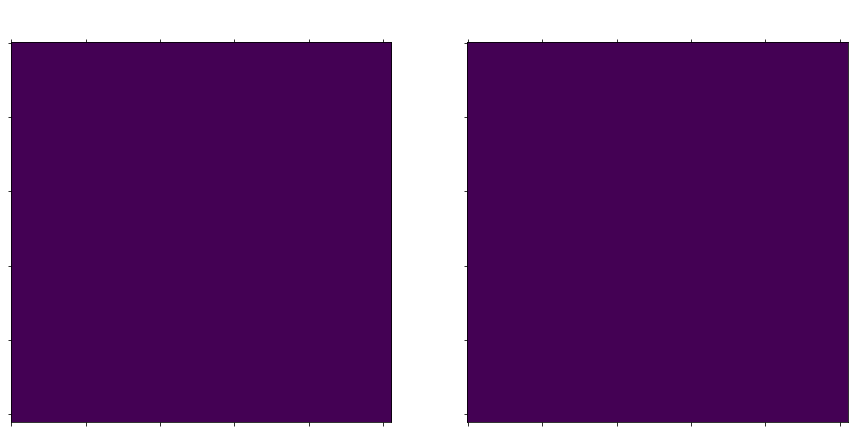

======== True vs Autoregressive Pred Frames  ========


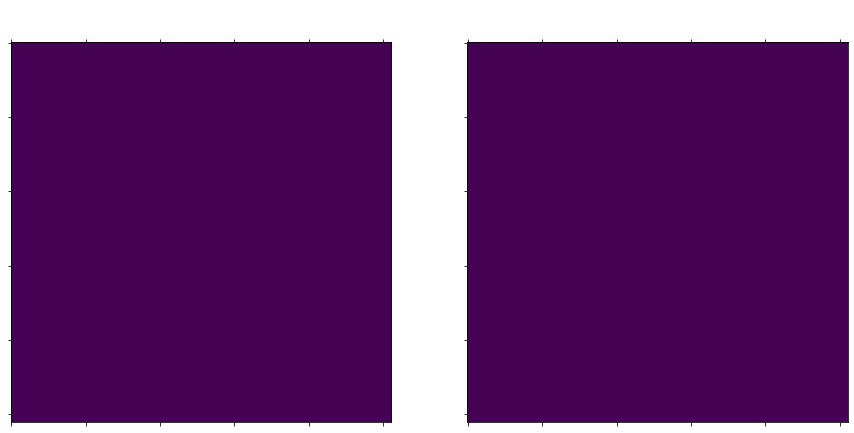

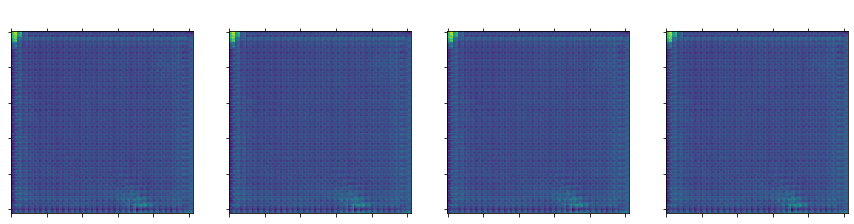

In [29]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

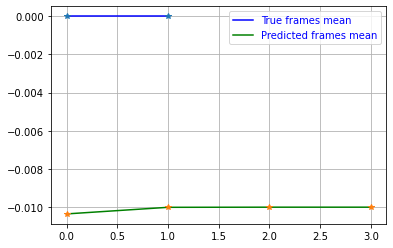

In [30]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [31]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -0.124222           0.897250            0.051546            0.061615            
true                0.000000            2.182364            0.038984            0.203834            
